# Fréquentation du dimanche : éléments quantitatifs

In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import datetime

from kiblib.utils.db import DbConn
from kiblib.utils.code2libelle import Code2Libelle
from kiblib.adherent import Adherent

In [74]:
class StatDimanche():
    def __init__(self, **kwargs):
        if 'db_conn' in kwargs:
            self.db_conn = kwargs.get('db_conn')
        else:
            raise Exception("Manque l'argument 'db_conn'.")
        if 'query' in kwargs:
            self.query = kwargs.get('query')
        else:
            raise Exception("Manque l'argument 'query'.")
        if 'dimanches_str' in kwargs:
            self.dimanches_str = kwargs.get('dimanches_str')
        else:
            raise Exception("Manque l'argument 'dimanches_str'.")
        if 'inscriptions' in kwargs:
            self.inscriptions = kwargs.get('inscriptions')
        else:
            self.inscriptions = False
        
        self.dimanches = [datetime.date.fromisoformat(d_str) for d_str in self.dimanches_str]
        self.semaines = [str(d.year) + "-" + str(d.isocalendar()[1]) for d in self.dimanches]
        
        self.df = pd.read_sql(self.query, con=self.db_conn)
        self.df['date_heure'] = pd.to_datetime(self.df['date_heure'])
        self.df['date'] = self.df['date_heure'].dt.date
        self.df['semaine'] = self.df['date_heure'].dt.year.astype(str) + "-" + self.df['date_heure'].dt.isocalendar().week.astype(str)
        self.df['semaine_simple'] = self.df['date_heure'].dt.isocalendar().week.astype(str)
        self.df['jour_semaine'] = self.df['date_heure'].dt.weekday
        if self.inscriptions == False:
            self.df['heure'] = self.df['date_heure'].dt.hour
            self.df = self.df[(self.df['heure'] >= 9) & (self.df['heure'] < 19)]
            self.df = self.df[~((self.df['jour_semaine'] == 6) & (self.df['heure'] < 14))]
            self.df = self.df[~((self.df['jour_semaine'] == 6) & (self.df['heure'] > 17))]
       
        if 'nombre' not in self.df:
            self.df['nombre'] = 1
        
        self.df = self.df[self.df['semaine'].isin(self.semaines)]
        
        self.df_semaine = self.df.groupby([self.df['semaine']])['nombre'].sum().to_frame().reset_index()
        self.df_semaine = self.df_semaine.rename(columns={'nombre':'nombre_semaine'})

        self.df_dimanche = self.df[self.df['date'].isin(self.dimanches)]
        
    def get_df_dimanche_date(self):
        self.df_dimanche_date = self.df_dimanche.groupby(['date', 'semaine'])['nombre'].sum().to_frame().reset_index()
        self.df_dimanche_date = pd.merge(self.df_dimanche_date, self.df_semaine, on= 'semaine', how='left')
        self.df_dimanche_date['moyenne_horaire_dimanche'] = self.df_dimanche_date['nombre'] / 4 
        self.df_dimanche_date['moyenne_horaire_dimanche'] = self.df_dimanche_date['moyenne_horaire_dimanche'].round().astype(int)
        self.df_dimanche_date['moyenne_horaire_semaine'] = self.df_dimanche_date['nombre_semaine'] / 55
        self.df_dimanche_date['moyenne_horaire_semaine'] = self.df_dimanche_date['moyenne_horaire_semaine'].round().astype(int)
 
    def get_df_dimanche_date_heure(self):
        self.df_dimanche_date_heure = self.df_dimanche.groupby(['date', 'heure'])['nombre'].sum().to_frame().reset_index()
        
    def get_df_dimanche_date_usagers(self):
        self.df_dimanche_date_usagers = self.df_dimanche.groupby(['date'])['usager'].nunique().to_frame().reset_index()
        
    def get_df_moyenne(self):
        self.df_moyenne = self.df_dimanche_date[['date', 'moyenne_horaire_dimanche', 'moyenne_horaire_semaine']]
        self.df_moyenne = self.df_moyenne.set_index("date")
        self.df_moyenne = self.df_moyenne.stack().reset_index()
        self.df_moyenne = self.df_moyenne.rename(columns={'level_1':'periode', 0:'moyenne'})
        
    def get_df_semaine_mediane(self, rescale=False):
        self.df_semaine_mediane = self.df.groupby(['semaine', 'jour_semaine', 'heure'])['nombre'].sum().to_frame().reset_index()
        self.df_semaine_mediane = self.df_semaine_mediane.groupby(['jour_semaine', 'heure'])['nombre'].median().to_frame().reset_index()
        if rescale:
            to_rescale = self.df_semaine_mediane[['nombre']]
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaler.fit(to_rescale)
            to_rescale = scaler.transform(to_rescale)
            self.df_semaine_mediane['nombre'] = to_rescale
        self.df_semaine_mediane = pd.pivot_table(self.df_semaine_mediane, values='nombre', index='heure', columns='jour_semaine', aggfunc='mean')
        jours = {0: "lundi", 1:"mardi", 2:"mercredi", 3:"jeudi", 4:"vendredi", 5:"samedi", 6:"dimanche"}
        for j in self.df_semaine_mediane.columns:
            self.df_semaine_mediane = self.df_semaine_mediane.rename(columns={ j: jours[j] })

In [147]:
db_conn = DbConn().create_engine()

c2l = Code2Libelle(db_conn)
c2l.get_val()

In [76]:
# on déclare les dimanches ouverts au format YYYY-MM-DD
dimanches_str = ['2022-09-11',
                 '2022-09-18',
                 '2022-09-25',
                 '2022-10-02',
                 '2022-10-09',
                 '2022-10-16']

In [77]:
usagers_dimanche = []

## Entrées

In [78]:
query = """
SELECT datetime as date_heure, entrees as nombre
FROM stat_entrees
WHERE YEAR(datetime) >= 2022
"""

entrees = StatDimanche(db_conn=db_conn, query=query, dimanches_str=dimanches_str)

entrees.get_df_dimanche_date()
entrees_dimanche_date = entrees.df_dimanche_date

entrees.get_df_dimanche_date_heure()
entrees_dimanche_date_heure = entrees.df_dimanche_date_heure

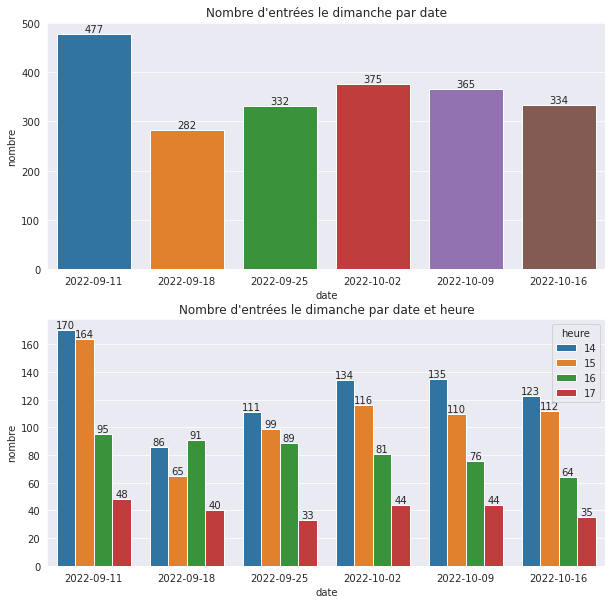

In [79]:
f, ax = plt.subplots(2, figsize=(10, 10))
#f.suptitle('Entrées')
sns.barplot(data=entrees_dimanche_date, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title("Nombre d'entrées le dimanche par date")
for i in ax[0].containers:
    ax[0].bar_label(i,)
sns.barplot(data=entrees_dimanche_date_heure, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title("Nombre d'entrées le dimanche par date et heure")
for i in ax[1].containers:
    ax[1].bar_label(i,)
#sns.barplot(data=entrees_moyenne, x= 'date', y='moyenne', hue='periode',ax=ax[2])
#ax[2].set_title("Comparaison entrées dimanche / semaine")
f.show()

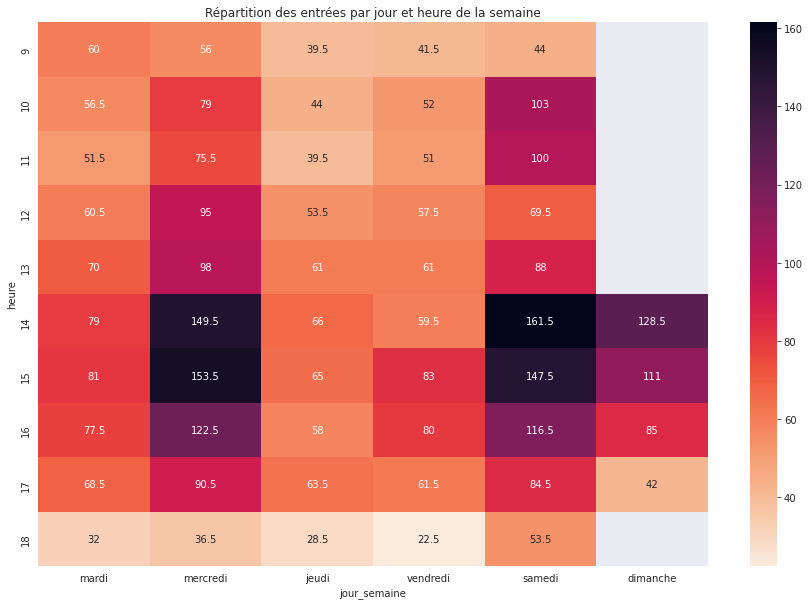

In [80]:
entrees.get_df_semaine_mediane(rescale=False)
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(entrees.df_semaine_mediane, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des entrées par jour et heure de la semaine")
f.show()

## Prêts

In [81]:
query = """
SELECT issuedate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(issuedate) >= '2022-09-01' AND location NOT IN ('MED0A', 'BUS1A')
"""
prets = StatDimanche(db_conn=db_conn, query=query, dimanches_str=dimanches_str)

prets.get_df_dimanche_date()
prets_dimanche_date = prets.df_dimanche_date

prets.get_df_dimanche_date_heure()
prets_dimanche_date_heure = prets.df_dimanche_date_heure

prets.get_df_dimanche_date_usagers()
prets_dimanche_date_usagers = prets.df_dimanche_date_usagers

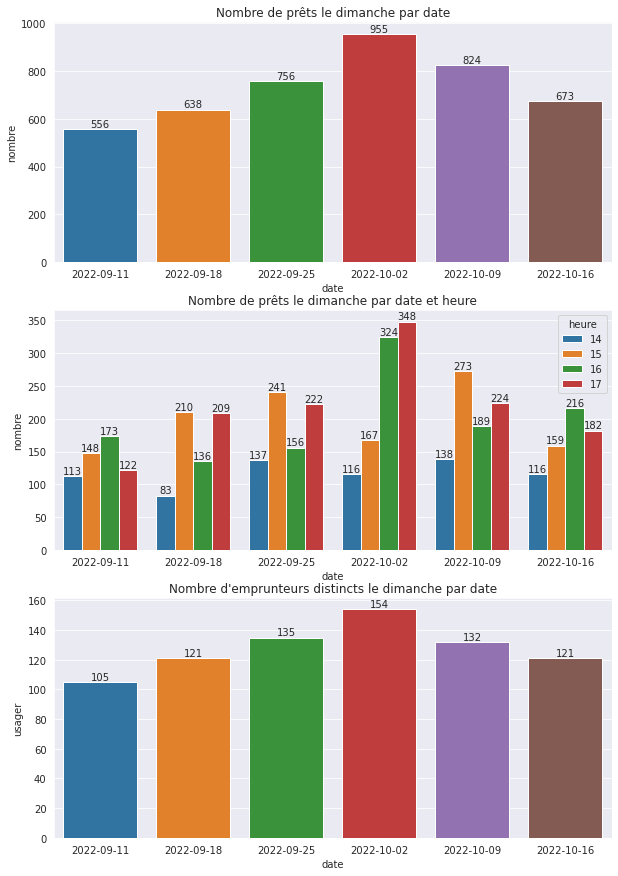

In [82]:
f, ax = plt.subplots(3, figsize=(10, 15))
#f.suptitle('Prêts')
sns.barplot(data=prets_dimanche_date, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title('Nombre de prêts le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
sns.barplot(data=prets_dimanche_date_heure, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title('Nombre de prêts le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
sns.barplot(data=prets_dimanche_date_usagers, x= 'date', y='usager', ax=ax[2])
ax[2].set_title("Nombre d'emprunteurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
#sns.barplot(data=prets_moyenne, x= 'date', y='moyenne', hue='periode',ax=ax[3])
#ax[3].set_title("Comparaison prêts dimanche / semaine")
f.show()

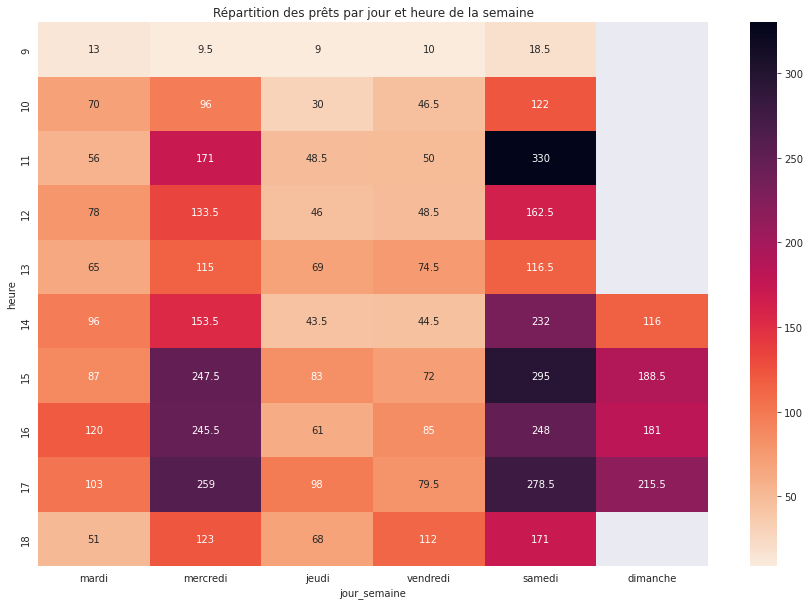

In [83]:
prets.get_df_semaine_mediane(rescale=False)
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(prets.df_semaine_mediane, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des prêts par jour et heure de la semaine")
f.show()

In [84]:
usagers_dimanche_prets = []
for usager in prets.df_dimanche['usager']:
    usagers_dimanche.append(usager)
    usagers_dimanche_prets.append(usager)

## Retours

In [85]:
query = """
SELECT returndate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(returndate) >= '2022-09-01' AND location NOT IN ('MED0A', 'BUS1A')
"""
retours = StatDimanche(db_conn=db_conn, query=query, dimanches_str=dimanches_str)

retours.get_df_dimanche_date()
retours_dimanche_date = retours.df_dimanche_date

retours.get_df_dimanche_date_heure()
retours_dimanche_date_heure = retours.df_dimanche_date_heure

retours.get_df_dimanche_date_usagers()
retours_dimanche_date_usagers = retours.df_dimanche_date_usagers

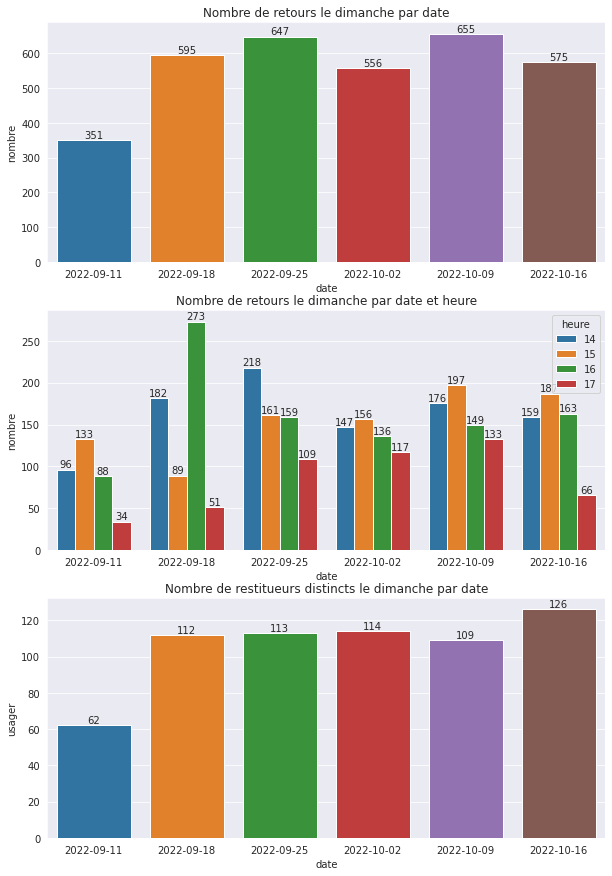

In [86]:
f, ax = plt.subplots(3, figsize=(10, 15))
#f.suptitle('retours')
sns.barplot(data=retours_dimanche_date, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title('Nombre de retours le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
sns.barplot(data=retours_dimanche_date_heure, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title('Nombre de retours le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
sns.barplot(data=retours_dimanche_date_usagers, x= 'date', y='usager', ax=ax[2])
ax[2].set_title("Nombre de restitueurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
#sns.barplot(data=retours_moyenne, x= 'date', y='moyenne', hue='periode',ax=ax[3])
#ax[3].set_title("Comparaison retours dimanche / semaine")
f.show()

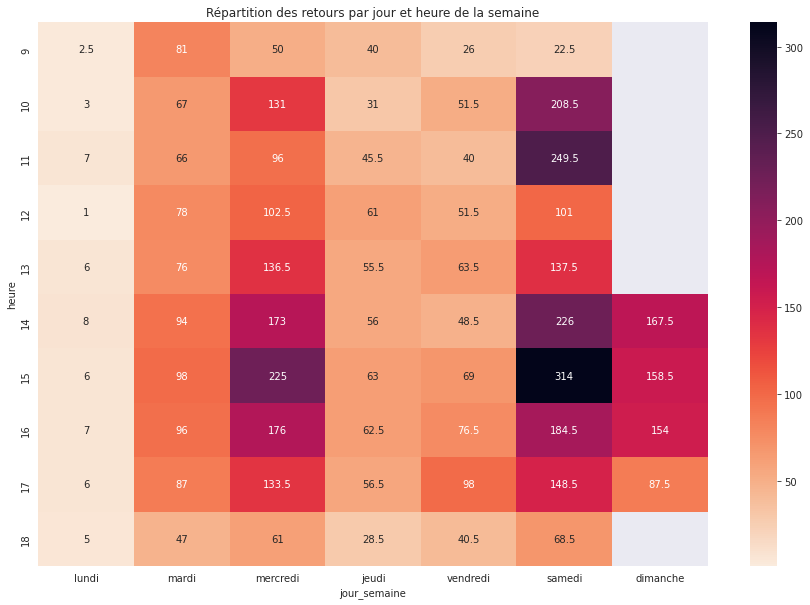

In [87]:
retours.get_df_semaine_mediane(rescale=False)
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(retours.df_semaine_mediane, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des retours par jour et heure de la semaine")
f.show()

In [88]:
usagers_dimanche_retours = []
for usager in retours.df_dimanche['usager']:
    usagers_dimanche.append(usager)
    usagers_dimanche_retours.append(usager)

## Connexions Webkiosk

In [89]:
query = """
SELECT heure_deb as date_heure, borrowernumber as usager
FROM stat_webkiosk
WHERE DATE(heure_deb) >= '2022-09-01'
"""

wk = StatDimanche(db_conn=db_conn, query=query, dimanches_str=dimanches_str)

wk.get_df_dimanche_date()
wk_dimanche_date = wk.df_dimanche_date

wk.get_df_dimanche_date_heure()
wk_dimanche_date_heure = wk.df_dimanche_date_heure

wk.get_df_dimanche_date_usagers()
wk_dimanche_date_usagers = wk.df_dimanche_date_usagers

wk.get_df_moyenne()
wk_moyenne = wk.df_moyenne

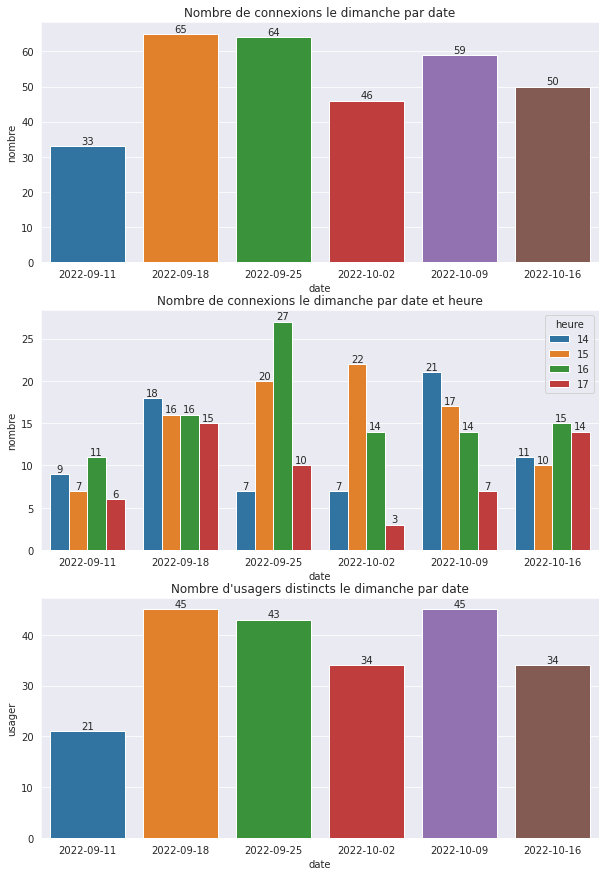

In [90]:
f, ax = plt.subplots(3, figsize=(10, 15))
#f.suptitle('Connexions aux postes informatiques')
sns.barplot(data=wk_dimanche_date, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title('Nombre de connexions le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
sns.barplot(data=wk_dimanche_date_heure, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title('Nombre de connexions le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
sns.barplot(data=wk_dimanche_date_usagers, x= 'date', y='usager', ax=ax[2])
ax[2].set_title("Nombre d'usagers distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
#sns.barplot(data=wk_moyenne, x= 'date', y='moyenne', hue='periode',ax=ax[3])
#ax[3].set_title("Comparaison connexions dimanche / semaine")
f.show()

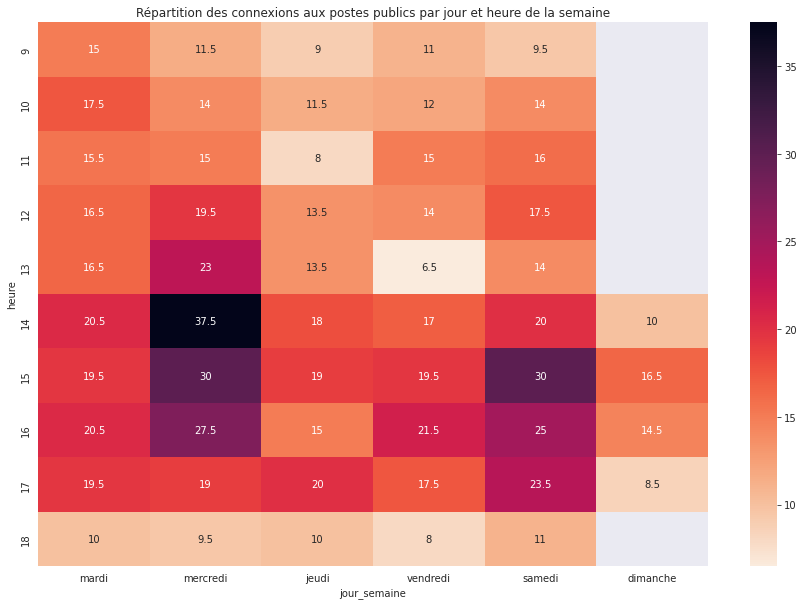

In [91]:
wk.get_df_semaine_mediane(rescale=False)
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(wk.df_semaine_mediane, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des connexions aux postes publics par jour et heure de la semaine")
f.show()

In [92]:
usagers_dimanche_wk = []
for usager in wk.df_dimanche['usager']:
    usagers_dimanche.append(usager)
    usagers_dimanche_wk.append(usager)

## Salle d'étude

In [93]:
query = """
SELECT datetime_entree as date_heure, borrowernumber as usager
FROM stat_freq_etude
WHERE DATE(datetime_entree) >= '2022-09-01'
"""

etude = StatDimanche(db_conn=db_conn, query=query, dimanches_str=dimanches_str)

etude.get_df_dimanche_date()
etude_dimanche_date = etude.df_dimanche_date

etude.get_df_dimanche_date_heure()
etude_dimanche_date_heure = etude.df_dimanche_date_heure

etude.get_df_dimanche_date_usagers()
etude_dimanche_date_usagers = etude.df_dimanche_date_usagers

etude.get_df_moyenne()
etude_moyenne = etude.df_moyenne

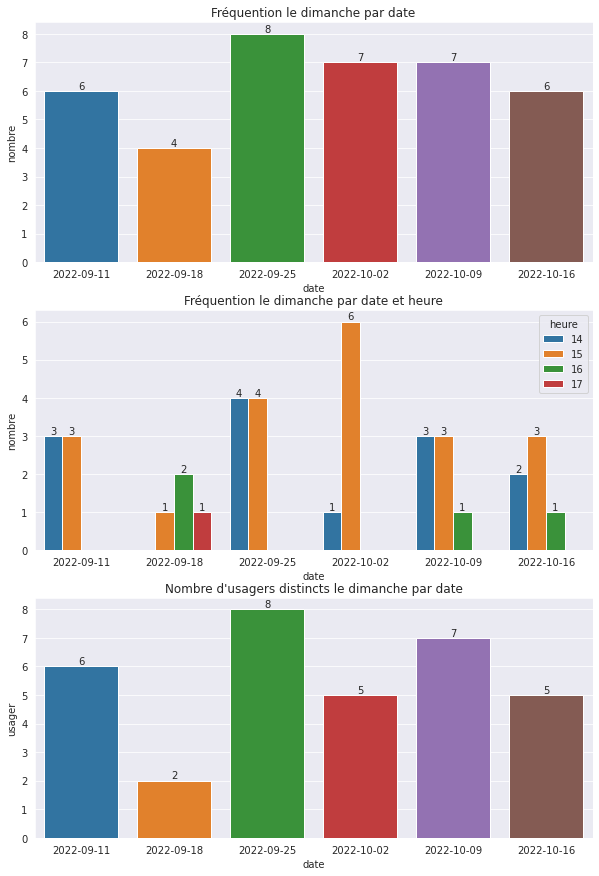

In [94]:
f, ax = plt.subplots(3, figsize=(10, 15))
#f.suptitle("Fréquention de la salle d'étude")
sns.barplot(data=etude_dimanche_date, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title('Fréquention le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
sns.barplot(data=etude_dimanche_date_heure, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title('Fréquention le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
sns.barplot(data=etude_dimanche_date_usagers, x= 'date', y='usager', ax=ax[2])
ax[2].set_title("Nombre d'usagers distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
#sns.barplot(data=etude_moyenne, x= 'date', y='moyenne', hue='periode',ax=ax[3])
#ax[3].set_title("Comparaison fréquentation dimanche / semaine")
f.show()

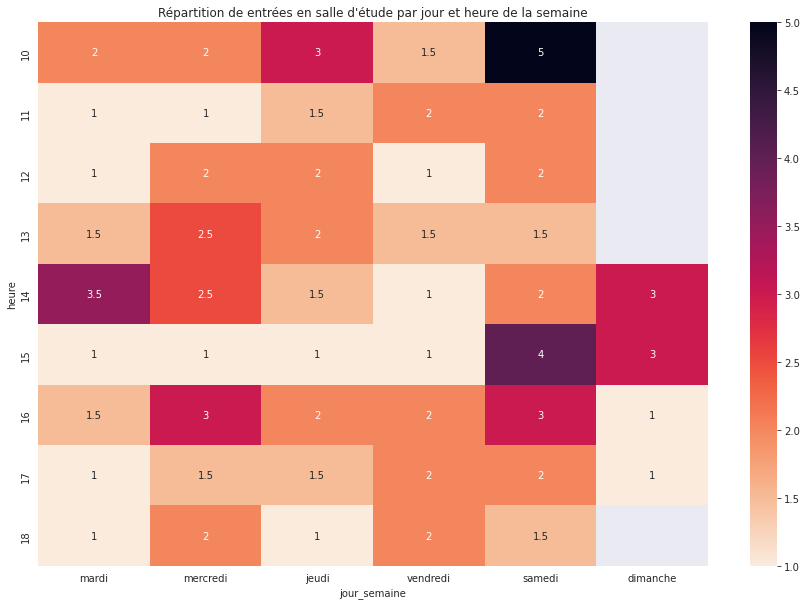

In [95]:
etude.get_df_semaine_mediane(rescale=False)
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(etude.df_semaine_mediane, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition de entrées en salle d'étude par jour et heure de la semaine")
f.show()

In [96]:
usagers_dimanche_etude = []
for usager in etude.df_dimanche['usager']:
    usagers_dimanche.append(usager)
    usagers_dimanche_etude.append(usager)

## Inscriptions

In [97]:
query = """
SELECT dateenrolled as date_heure, borrowernumber as usager
FROM koha_prod.borrowers
WHERE DATE(dateenrolled) >= '2022-09-01'
"""

inscriptions = StatDimanche(db_conn=db_conn, query=query, dimanches_str=dimanches_str, inscriptions=True)

inscriptions.get_df_dimanche_date()
inscriptions_dimanche_date = inscriptions.df_dimanche_date

inscriptions.get_df_dimanche_date_usagers()
inscriptions_dimanche_date_usagers = inscriptions.df_dimanche_date_usagers

inscriptions.get_df_moyenne()
inscriptions_moyenne = inscriptions.df_moyenne

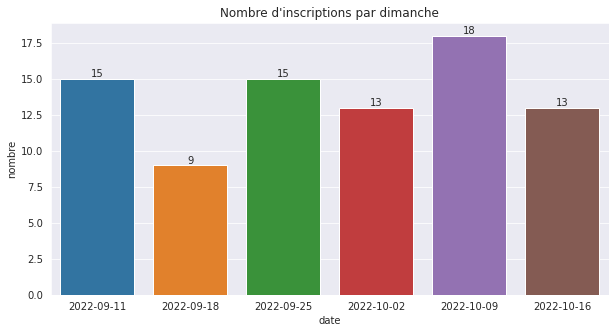

In [98]:
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=inscriptions_dimanche_date, x= 'date', y='nombre', ax=ax)
for i in ax.containers:
    ax.bar_label(i,)
ax.set_title("Nombre d'inscriptions par dimanche")
f.show()

In [99]:
usagers_dimanche_inscriptions = []
for usager in inscriptions.df_dimanche['usager']:
    usagers_dimanche.append(usager)
    usagers_dimanche_inscriptions.append(usager)

Questions :
- quel est le profil des personnes qui viennent le dimanche ? différent du profil des personnes qui viennent en semaine ?
- at-on des personnes qui ne viennent que le dimanche ?

In [134]:
df_usagers_dimanche = pd.Series(usagers_dimanche)
usagers_dimanche_dedupl = df_usagers_dimanche.dropna().astype(int).sort_values().drop_duplicates().astype(str).tolist()

In [137]:
borrower_in = ", ".join(usagers_dimanche_dedupl)

In [159]:
query = f"""
SELECT borrowernumber, cardnumber, title, dateofbirth, city, altcontactcountry, branchcode, categorycode, dateenrolled
FROM koha_prod.borrowers
WHERE borrowernumber IN ({borrower_in})
"""
df = pd.read_sql(query, db_conn)

In [160]:
adh_dimanche = Adherent(df=df, con=db_conn, c2l=c2l.dict_codes_lib)

adh_dimanche.get_adherent_statdb_data()
adh_dimanche.get_adherent_es_data()

/home/kibini/miniconda3/envs/kibini/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [161]:
adh_dimanche.df

,borrowernumber,cardnumber,title,dateofbirth,city,altcontactcountry,branchcode,categorycode,dateenrolled,adh_id,...,adh_inscription_carte_type,adh_inscription_carte_gratuite,adh_inscription_carte_prix,adh_inscription_carte_personnalite,adh_inscription_site,adh_inscription_nb_annees_adhesion_tra,adh_inscription_attribut_action,adh_inscription_attribut_bus,adh_inscription_attribut_collect,adh_inscription_attribut_pcs
0,328,X0001479074,Madame,1945-09-10,HEM,None,MED,BIBL,2005-03-31,7ddf5bba05,...,Médiathèque,gratuite,0,Personne,Médiathèque,g/ Plus de 10 ans,NaN,NaN,NaN,NaN
1,475,X0002123370,Madame,1949-05-22,ROUBAIX,595120603,MED,BIBL,2005-03-31,8e0c7020bd,...,Médiathèque,gratuite,0,Personne,Médiathèque,g/ Plus de 10 ans,NaN,NaN,NaN,NaN
2,511,X0002324043,Madame,1961-01-13,WASQUEHAL,None,MED,MEDA,2005-03-31,5fa8e8859c,...,Médiathèque Plus,payante,35,Personne,Médiathèque,g/ Plus de 10 ans,NaN,NaN,NaN,NaN
3,594,X0001836284,Madame,1996-10-05,ROUBAIX,595120801,MED,BIBL,2010-07-13,ce83ba3823,...,Médiathèque,gratuite,0,Personne,Médiathèque,g/ Plus de 10 ans,NaN,NaN,NaN,NaN
4,901,X0001973938,Madame,1950-10-18,ROUBAIX,595120701,MED,BIBL,2013-06-11,24c51f5cc4,...,Médiathèque,gratuite,0,Personne,Médiathèque,f/ 5 - 10 ans,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,68690,X0002585246,Madame,2002-09-25,LILLE,None,MED,CSLT,2022-10-16,bfd61e0481,...,Consultation sur place,gratuite,0,Personne,Médiathèque,a/ 0,NaN,NaN,NaN,NaN
871,68691,X0002585253,Madame,1994-11-30,ROUBAIX,595120801,MED,BIBL,2022-10-16,83f41e7717,...,Médiathèque,gratuite,0,Personne,Médiathèque,a/ 0,NaN,NaN,NaN,NaN
872,68692,X0002585260,Madame,2020-07-10,ROUBAIX,595120504,MED,BIBL,2022-10-16,9177501e42,...,Médiathèque,gratuite,0,Personne,Médiathèque,a/ 0,NaN,NaN,NaN,NaN
873,68693,X0002585277,Madame,2016-06-22,ROUBAIX,595120303,MED,BIBL,2022-10-16,36d42e8e14,...,Médiathèque,gratuite,0,Personne,Médiathèque,a/ 0,NaN,NaN,NaN,NaN


In [162]:
adh_dimanche.df.columns

Index(['borrowernumber', 'cardnumber', 'title', 'dateofbirth', 'city',
       'altcontactcountry', 'branchcode', 'categorycode', 'dateenrolled',
       'adh_id', 'adh_inscription_carte_code',
       'adh_inscription_carte_personnalite_code', 'adh_sexe_code', 'age',
       'adh_age_code', 'adh_geo_ville', 'adh_geo_ville_bm',
       'adh_geo_ville_limitrophe', 'adh_geo_rbx_iris_code',
       'adh_inscription_site_code', 'adh_inscription_nb_annees_adhesion',
       'adh_inscription_attribut_action_code',
       'adh_inscription_attribut_bus_code',
       'adh_inscription_attribut_collect_code',
       'adh_inscription_attribut_pcs_code', 'adh_sexe', 'adh_age_lib1',
       'adh_age_lib2', 'adh_age_lib3', 'adh_geo_gentilite', 'adh_geo_rbx_iris',
       'adh_geo_rbx_quartier', 'geo_rbx_secteur', 'inscription_carte',
       'adh_inscription_carte_type', 'adh_inscription_carte_gratuite',
       'adh_inscription_carte_prix', 'adh_inscription_carte_personnalite',
       'adh_inscription_site', '

In [164]:
columns_to_keep = ['borrowernumber', 'adh_geo_ville', 'adh_geo_ville_bm',
       'adh_geo_ville_limitrophe', 'adh_sexe', 'adh_age_lib1',
       'adh_age_lib2', 'adh_age_lib3', 'adh_geo_gentilite', 'adh_geo_rbx_iris',
       'adh_geo_rbx_quartier', 'geo_rbx_secteur', 'inscription_carte',
       'adh_inscription_carte_type', 'adh_inscription_carte_gratuite',
       'adh_inscription_carte_prix', 'adh_inscription_carte_personnalite',
       'adh_inscription_site', 'adh_inscription_nb_annees_adhesion_tra',
       'adh_inscription_attribut_action', 'adh_inscription_attribut_bus',
       'adh_inscription_attribut_collect', 'adh_inscription_attribut_pcs']
df_adh_dimanche = adh_dimanche.df[columns_to_keep]
df_adh_dimanche

,borrowernumber,adh_geo_ville,adh_geo_ville_bm,adh_geo_ville_limitrophe,adh_sexe,adh_age_lib1,adh_age_lib2,adh_age_lib3,adh_geo_gentilite,adh_geo_rbx_iris,...,adh_inscription_carte_type,adh_inscription_carte_gratuite,adh_inscription_carte_prix,adh_inscription_carte_personnalite,adh_inscription_site,adh_inscription_nb_annees_adhesion_tra,adh_inscription_attribut_action,adh_inscription_attribut_bus,adh_inscription_attribut_collect,adh_inscription_attribut_pcs
0,328,HEM,non,limitrophe,Féminin,65 - 79 ans,15 ans et plus,65 ans et plus,Non Roubaisien,NaN,...,Médiathèque,gratuite,0,Personne,Médiathèque,g/ Plus de 10 ans,NaN,NaN,NaN,NaN
1,475,ROUBAIX,ville_bm,limitrophe,Féminin,65 - 79 ans,15 ans et plus,65 ans et plus,Roubaisien,ANSEELE,...,Médiathèque,gratuite,0,Personne,Médiathèque,g/ Plus de 10 ans,NaN,NaN,NaN,NaN
2,511,WASQUEHAL,ville_bm,non,Féminin,55 - 64 ans,15 ans et plus,25 - 64 ans,Non Roubaisien,NaN,...,Médiathèque Plus,payante,35,Personne,Médiathèque,g/ Plus de 10 ans,NaN,NaN,NaN,NaN
3,594,ROUBAIX,ville_bm,limitrophe,Féminin,25 - 29 ans,15 ans et plus,25 - 64 ans,Roubaisien,MOULIN NORD,...,Médiathèque,gratuite,0,Personne,Médiathèque,g/ Plus de 10 ans,NaN,NaN,NaN,NaN
4,901,ROUBAIX,ville_bm,limitrophe,Féminin,65 - 79 ans,15 ans et plus,65 ans et plus,Roubaisien,BARBIEUX-VAUBAN,...,Médiathèque,gratuite,0,Personne,Médiathèque,f/ 5 - 10 ans,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,68690,LILLE,ville_bm,non,Féminin,20 - 24 ans,15 ans et plus,15 - 24 ans,Non Roubaisien,NaN,...,Consultation sur place,gratuite,0,Personne,Médiathèque,a/ 0,NaN,NaN,NaN,NaN
871,68691,ROUBAIX,ville_bm,limitrophe,Féminin,25 - 29 ans,15 ans et plus,25 - 64 ans,Roubaisien,MOULIN NORD,...,Médiathèque,gratuite,0,Personne,Médiathèque,a/ 0,NaN,NaN,NaN,NaN
872,68692,ROUBAIX,ville_bm,limitrophe,Féminin,0 - 2 ans,<= 14 ans,0 - 14 ans,Roubaisien,TRICHON,...,Médiathèque,gratuite,0,Personne,Médiathèque,a/ 0,NaN,NaN,NaN,NaN
873,68693,ROUBAIX,ville_bm,limitrophe,Féminin,06 - 10 ans,<= 14 ans,0 - 14 ans,Roubaisien,CUL DE FOUR,...,Médiathèque,gratuite,0,Personne,Médiathèque,a/ 0,NaN,NaN,NaN,NaN


In [167]:
df_adh_dimanche['adh_geo_gentilite'].value_counts(normalize=True)

Roubaisien        0.712
Non Roubaisien    0.288
Name: adh_geo_gentilite, dtype: float64